# OpenPTV calibration using given markers and liboptv

In [62]:
# liboptv is different from openptv_python cause it's a C library with Cython bindings. requires different installation

In [63]:

import numpy as np
from scipy.optimize import minimize

import pathlib, os
working_path = pathlib.Path.cwd()

In [64]:
n_cams = 4

from optv.parameters import ControlParams, VolumeParams
cpar = ControlParams(n_cams)
cpar.read_control_par(b"parameters/ptv.par")


In [65]:
cpar.get_image_size()

(2560, 2048)

In [66]:

vpar = VolumeParams()
vpar.read_volume_par(b"parameters/criteria.par")
vpar.get_Zmin_lay(), vpar.get_Zmax_lay()

(array([-50., -50.]), array([1500., 1500.]))

In [67]:
from optv.calibration import Calibration

In [68]:
cals = []
for i_cam in range(n_cams):
    cal = Calibration()
    tmp = cpar.get_cal_img_base_name(i_cam)
    print(tmp)
    cal.from_file(tmp + b".ori", tmp + b".addpar")
    print(cal.get_pos(), cal.get_angles())
    cals.append(cal)

b'calibration/cam1.tif'
[1908.5163676   159.83947734 3792.73650968] [ 0.0767755   0.43684216 -0.02824231]
b'calibration/cam2.tif'
[1918.50582672 2013.94616486 3790.84376551] [-0.54238883  0.38101067  0.22269959]
b'calibration/cam3.tif'
[-832.68057493  140.62429132 3808.29859692] [ 0.07130939 -0.39820728  0.02391263]
b'calibration/cam4.tif'
[-795.65582216 1982.45343091 3867.24986954] [-0.51564722 -0.33215712 -0.17554908]


In [69]:

# from optv.transforms import convert_arr_metric_to_pixel
# from optv.imgcoord import image_coordinates

# for plane_z in [0, 350, 700, 1050, 1400]:
#     for cam in range(n_cams):

#         # Save the modified data to a new file
#         data = np.loadtxt(f'calibration/modified_plane_{plane_z}.txt')
#         targets = convert_arr_metric_to_pixel(
#             image_coordinates(data[:,1:], cals[cam], cpar.get_multimedia_params()),
#         cpar,
#         )

#         # Combine targets and corresponding XYZ data
#         combined_data = np.hstack((targets, data[:, 1:]))

#         # Save to CSV file
#         # np.savetxt(f'calibration/cam_{cam}_plane_{plane_z}.csv', combined_data, delimiter=',', header='x,y,X,Y,Z', comments='')


In [70]:
from flowtracks.io import trajectories_table
trajects = trajectories_table('/home/user/Dropbox/dataset_25.1.2022/notebooks/trajectories_longerthan50.h5')

In [71]:
import numpy as np
mins = [np.min(tr.pos(),axis=0) for tr in trajects]
maxs = [np.max(tr.pos(),axis=0) for tr in trajects]
mins = np.min(mins, axis=0)
maxs = np.max(maxs, axis=0)
mins, maxs

(array([-0.484757, -0.193176, -0.075333]),
 array([1.381215, 1.008148, 1.510503]))

In [72]:
tmp = np.meshgrid( np.arange(-480, 1380, 80),  np.arange(-200, 1020, 80) )
tmp = np.array(tmp).T.reshape(-1, 2)

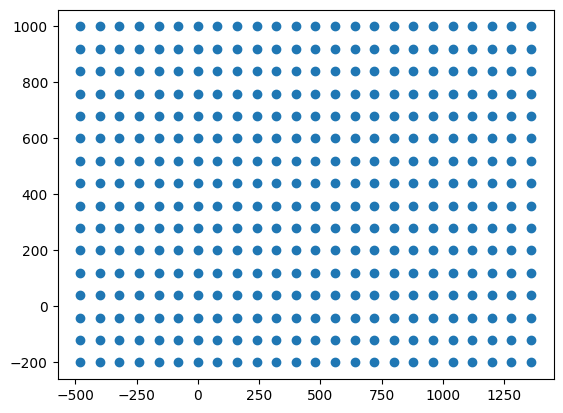

In [73]:

import matplotlib.pyplot as plt
plt.scatter(tmp[:,0], tmp[:,1])

In [75]:
from optv.transforms import convert_arr_metric_to_pixel
from optv.imgcoord import image_coordinates

for plane_z in [0, 350, 700, 1050, 1400]:
    for cam in range(4): # 4 = n_cams

        # Save the modified data to a new file
        # data = np.loadtxt(f'calibration/new_plane_{plane_z}.txt')
        data = np.hstack((tmp, np.full((tmp.shape[0], 1), plane_z)))
        targets = convert_arr_metric_to_pixel(
            image_coordinates(data.astype(np.float64), cals[cam], cpar.get_multimedia_params()),
        cpar,
        )

        # Combine targets and corresponding XYZ data
        combined_data = np.hstack((targets, data[:, 1:]))

        # Save to CSV file
        np.savetxt(f'newcal/cam_{cam}_plane_{plane_z}.csv', combined_data, delimiter=',', header='x,y,X,Y,Z', comments='')